### 下载和缓存数据集

In [1]:
import hashlib
import os
import zipfile
import tarfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

#### `download`函数用来下载数据集，将数据集缓存在本地目录，并返回文件的名称  
如果缓存目录中已经存在此数据集文件，并且其sha-1与储存在`DATA_HUB`中的想匹配，将使用缓存的文件，**以避免重复下载**

- 'url.split('/')[-1]'：将 URL 按照斜杠进行分割，得到一个列表，取出列表的最后一个元素，通常是 URL 中的文件名

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

### 使用`pandas`读入并处理数据

In [70]:
import pandas as pd
import numpy as np
import torch

from torch.utils import data
from torch import nn
from d2l import torch as d2l

In [4]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce'
)
DATA_HUB['kaggle_house_test'] = ( 
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
)

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...


- `.iloc[行索引，列索引]`pandas中对dataframe进行位置索引
- `pd.concat(objs, axis=0)`沿着指定的轴将多个dataframe或series进行拼接  
    - 注：是一个`objs`

In [6]:
print(train_data.shape, test_data.shape)
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

(1460, 81) (1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [104]:
all_features = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]])

### 数据预处理
- **将所有缺失的值替换为相应特征的平均值**
- **通过将特征重新缩放到0均值和单位方差来标准化数据**

- `.dtypes`返回dataframe中**每一列**的数据类型
- `object`是非数值型数据
- `.apply()`将函数应用到dataframe的每一列上
- `.index`返回索引，即列名——在此，得到包含所有数值特征的列名

In [105]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 与表示标准化后的均值一样

- **处理离散值，用独热编码one-hot-encoding替换**

- `pd.get_dummies(data)`是pandas中用于将分类变量（如文本或分类数据）转换为**独热编码**形式的函数
    - `dummy_na=True`会在独热编码时为NaN单独生成一个新列，该列值为1表示该行的该列原本是缺失值
    - 对`bool`类型无用
- 这下面写的是不对的，**要跳过**，应该默认类型是`int`才行

In [27]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

#### 将data转为**张量**的形式
- **`values`属性，从pandas格式中提取numpy格式**
- `torch.tensor()`
- `data.列名`使用对象的属性方位方式来直接获取列：`train_data.SalePrice`

#### 要将`bool`转为数据类型，才能进一步转tensor
- 不然就会一直说有'object'类型，明明都验证了没有，但是不知道原因...

In [34]:
object_index = all_features.dtypes[all_features.dtypes == 'object'].index
object_index

Index([], dtype='object')

In [61]:
bool_index = all_features.dtypes[all_features.dtypes == 'bool'].index
all_features[bool_index] = all_features[bool_index].astype(float)

In [65]:
n_train = train_data.shape[0]
train_features_1 = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

#### **注意**
新的pandas版本，`pd.get_dummies`默认是`bool`类型，**需要改为`int、np.int32`才行！**

In [106]:
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

### 训练

- 带有损失平方的**线性模型**
    - 线性模型提供了一种健全性检查，查看数据汇总是否存在有意义的信息
    - 如果不能做的比随机猜测更好，很可能存在数据处理错误
    - 如果一切顺利，作为**基线**模型，能直观的知道最好的的模型有超出简单的模型多少

In [71]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

#### 对于房价预测，更关心**相对误差**
* 用**对数衡量差异**——为了解决相对误差的问题，使用房价的对数进行差异衡量
    - 好处：能够**处理不同量级的数据**
- **均方根误差**（RMSE）
$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.
$$
RMSE衡量的是对数空间中预测与实际之间的差异，能够**有效捕捉相对误差的大小**
- 均方根误差通常在训练过程汇总用于**评估模型的性能！**

- 为了在去对数时进一步稳定该值，**将小于1的值设置为1**
- `torch.clamp(input, min, max)`：会将`input`中小于`min`的设为`min`，大于`max`的值设置为`max`
- `float(inf)`表示**正无穷**
- `.item()`注意！

In [72]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

#### 训练
- 训练函数使用**Adam**优化器
    - 主要的吸引力：**对初始学习率不那么敏感**
- **在训练时，使用的还是`loss`函数**
- 均方根误差通常在训练过程汇总用于**评估模型的性能！**

In [102]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs,lr, batch_size, weight_decay):
    train_ls, test_ls = [], []
    # dataset = data.TensorDataset(*(train_features, train_labels))
    # train_iter = data.DataLoader(dataset, batch_size, shuffle=True)
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    trainer = torch.optim.Adam(net.parameters(), 
                               lr=lr, 
                               weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y) 
            l.backward()
            trainer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### $K$折交叉验证

- `slice(start, stop, step)`可以创建一个切片对象，用于**索引**，可以直接用在list、数组、dataframe、张量中
- `torch.cat`用于将多个张量沿指定维度连接在一起

In [75]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid        

- 当在$K$折交叉验证中训练$K$次后，**返回训练和验证误差的平均值**


In [114]:
def k_fold(k, X_train, y_train, num_epochs, lr, weight_decay, batch_size):
    train_ls_sum, valid_ls_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs,
                                  lr, batch_size, weight_decay)
        train_ls_sum += train_ls[-1]
        valid_ls_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs +1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'{i + 1}折，训练log rmse{float(train_ls[-1]):f}',
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_ls_sum / k, valid_ls_sum / k

### 模型选择
- **需要各种调参**

1折，训练log rmse0.169982 验证log rmse0.156450
2折，训练log rmse0.162433 验证log rmse0.189705
3折，训练log rmse0.163738 验证log rmse0.168118
4折，训练log rmse0.168068 验证log rmse0.154520
5折，训练log rmse0.162781 验证log rmse0.182703
5-折验证: 平均训练log rmse: 0.165400, 平均验证log rmse: 0.170299


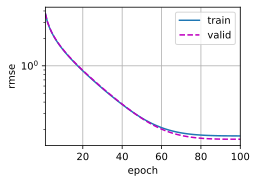

In [125]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

**增加K折交叉验证的折数**可以提高模型性能评估的**稳定性和泛化行**，更**精确**地评估模型的表现

1折，训练log rmse0.166634 验证log rmse0.163638
2折，训练log rmse0.166401 验证log rmse0.144172
3折，训练log rmse0.165973 验证log rmse0.156977
4折，训练log rmse0.159159 验证log rmse0.222619
5折，训练log rmse0.161512 验证log rmse0.195582
6折，训练log rmse0.165939 验证log rmse0.130518
7折，训练log rmse0.167087 验证log rmse0.139510
8折，训练log rmse0.164117 验证log rmse0.165440
9折，训练log rmse0.162080 验证log rmse0.204724
10折，训练log rmse0.165434 验证log rmse0.152740
10-折验证: 平均训练log rmse: 0.164434, 平均验证log rmse: 0.167592


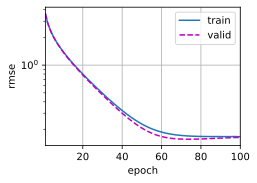

In [108]:
k, num_epochs, lr, weight_decay, batch_size = 10, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

1折，训练log rmse0.170249 验证log rmse0.156506
2折，训练log rmse0.162387 验证log rmse0.190715
3折，训练log rmse0.163888 验证log rmse0.168198
4折，训练log rmse0.167460 验证log rmse0.154624
5折，训练log rmse0.163187 验证log rmse0.182853
5-折验证: 平均训练log rmse: 0.165434, 平均验证log rmse: 0.170579


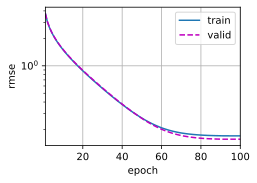

In [109]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0.001, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

### 提交Kaggle预测
- 选好超参数后，使用所有数据对其进行训练
- 将预测保存到一个CSV文件
    - **使用位置参数后就不要使用关键词参数**

    #### **注意**：**使用位置传参时，一定要注意位置！！**

In [152]:
def trian_and_pred(train_features, train_labels, test_features, 
                   test_data, num_epochs, lr, batch_size, weight_decay):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, 
                        None, None, num_epochs, 
                        lr, batch_size, weight_decay
                       )
    d2l.plot(np.arange(1, num_epochs + 1), train_ls, xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse:{train_ls[-1]:f}')

    preds = net(test_features).detach().numpy()
    # 重新格式化以到处到Kaggle
    # 或者：`reshape(-1)
    test_data['SalePrice'] = pd.Series(preds.reshape(-1))      
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('..\data\submission.csv', index=False)

训练log rmse:0.516985


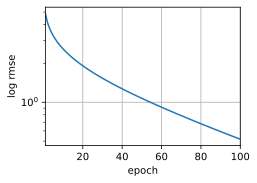

In [153]:
batch_size = 256
trian_and_pred(train_features, train_labels, test_features,
               test_data, num_epochs, lr, batch_size, weight_decay)

### 小结

* 真实数据通常混合了不同的数据类型，需要进行预处理。
* 常用的预处理方法：将实值数据重新缩放为零均值和单位方法；用均值替换缺失值。
* 将类别特征转化为指标特征，可以使我们把这个特征当作一个独热向量来对待。
* 我们可以使用$K$折交叉验证来选择模型并调整超参数。
* 对数对于相对误差很有用。

### 练习

1. 能通过直接最小化价格的对数来改进模型吗？如果试图预测价格的对数而不是价格，会发生什么？
1. 用平均值替换缺失值总是好主意吗？提示：能构造一个不随机丢失值的情况吗？
1. 通过$K$折交叉验证调整超参数，从而提高Kaggle的得分。
1. 通过改进模型（例如，层、权重衰减和dropout）来提高分数。
1. 如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？


- `.iloc[row, column]`是pandas库，可以通过**数字位置**进行访问
- `net.train()`设置模型为训练模式，确保`Dropout`和`Batch Normalization`正常工作

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch.utils import data
from d2l import torch as d2l
from torch import nn

train_data = pd.read_csv('..\data\kaggle_house_pred_train.csv')
test_data = pd.read_csv('..\data\kaggle_house_pred_test.csv')

all_features = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]], axis=0)  # 不要id

# 将数据标准化
numeric_index = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_index] = all_features[numeric_index].apply(
    lambda x: (x - x.mean()) / x.std()
)
all_features[numeric_index] = all_features[numeric_index].fillna(0)

all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)
n_train = train_data.shape[0]

train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features.iloc[n_train:, :].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

in_features = train_features.shape[1]

## **数据没有问题！**  
**结果不对，看是否是net的问题**  
**log的位置**

In [247]:
loss = nn.MSELoss()

def losslogtestfunc(net,features, labels):
    return loss(net(features), labels).item()

def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
# def init_weights(m):
#     if type(m) == nn.Linear:
#         m.reset_parameters()

# 这个函数意义是什么？
# class Net(nn.Module):
#     def __init__(self, num_inputs=in_features, num_outputs=1):
#         self.num_inputs = num_inputs
#         super(Net, self).__init__()
#         self.lin1 = nn.Linear(num_inputs, num_outputs)

#     def forward(self, X):
#         H1 = self.lin1(X.reshape((-1, self.num_inputs)))
#         clipped_preds = torch.log(torch.clamp(H1, 1, float('inf')))
#         out = clipped_preds
#         return out

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def train(net, l, train_features, train_labels, test_features, test_labels, 
          num_epochs, lr, weight_decay, batch_size, testfunc=log_rmse
         ):
    train_ls, test_ls = [], []
    dataset = data.TensorDataset(*(train_features, train_labels))
    train_iter = data.DataLoader(dataset, batch_size, shuffle=True)
    # train_iter = d2l.load_array((train_features, train_labels), batch_size)
    trainer = torch.optim.Adam(net.parameters(), lr=lr, 
                              weight_decay=weight_decay)
    for epoch in range(num_epochs):
        net.train() # 设置模型为训练模式
        for X, y in train_iter:
            trainer.zero_grad()
            ll = l(net(X), y)
            ll.backward()
            trainer.step()
        # net.eval()
        train_ls.append(testfunc(net, X, y))
        
        if test_labels is not None:
            net.eval()
            test_ls.append(testfunc(net, test_features, test_labels)) #####
    return train_ls, test_ls
    
def get_k_flod_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]  ######
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, l, net, X_train, y_train, num_epochs, lr,
           weight_decay, batch_size, is_show=True, testfunc=log_rmse):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_flod_data(k, i, X_train, y_train)
        net.apply(init_weight)
        train_ls, valid_ls = train(net, l, *data, num_epochs, lr, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if (i == 0) & (is_show == True):
            # plt.plot(list(range(num_epochs)), np.array(train_ls), label='train')
            # plt.plot(torch.arange(num_epochs), np.array(valid_ls), label='valid')
            
            # ## log_rmse没有 `.item()`
            # # plt.plot(list(range(num_epochs)), np.array([l.detach().numpy() for l in train_ls]), label='train')
            # # plt.plot(torch.arange(num_epochs), np.array([l.detach().numpy() for l in valid_ls]), label='valid')
           
            # plt.xlabel('epoch')
            # plt.ylabel('rmse')
            # plt.xlim([1, num_epochs])
            # plt.yscale('log')         # 设y是对数刻度
            # plt.legend()
            # plt.grid(True)            # 添加网格
            # plt.show()
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        if is_show == True:
            print(f'折{i + 1}，训练lof rmse{float(train_ls[-1]):f}',
                 f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练lof rmse0.439779 验证log rmse1.003726
折2，训练lof rmse0.352906 验证log rmse0.445521
折3，训练lof rmse2.412028 验证log rmse2.285139
折4，训练lof rmse1.557311 验证log rmse1.443693
折5，训练lof rmse1.097087 验证log rmse1.439308
5折交叉验证，平均训练log rmse:1.171822 平均验证log rmse: 1.323478


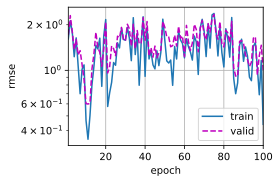

In [248]:
net = get_net()
k, num_epochs, lr, weigh_decay, batch_size = 5, 100, 5, 0, 64 
train_l, valid_l = k_fold(k, loss, net, train_features, torch.log(train_labels), 
                          num_epochs, lr, weight_decay, batch_size, testfunc=losslogtestfunc)
print(f'{k}折交叉验证，平均训练log rmse:{float(train_l):f}',
     f'平均验证log rmse: {float(valid_l):f}')